# Protfolio optimization with CIM

## Equations

### Optimization problem formulation

Potential:
$$
V(\omega; \mu, \Theta) = \sum_{ij}^N -\mu_i \omega_i + \frac{\gamma}{2} \Theta_{ij} \omega_i \omega_j 
$$
Constraints:


-Allocations (Box constraints)
$$
\sum_{i \in I_k} \omega_i \leq \lambda_{I_k}
$$
for some subsets $I_k \subseteq \left[ N \right]$, whre $k \in [M']$ 

-Budget constraints 
$$
\sum_{i \in J_k} \omega_i = \lambda_{J_k}
$$
for some subsets $J_k \subseteq \left[ N \right]$, whre $k \in [M]$ , with $\lambda_{\left[ N \right]} = \lambda_0 = 1$

-Continuous formulation of budget constraints (with lagrange multiplier $\rho$)
$$
U(\omega; u, \lambda) = -\rho \sum_{k=0}^M \sum_i \left[ (u_k)_i \omega_i - \lambda_k \right]^2
$$
where $(u_k)_i = 1$ if the $i^{\text{th}}$ asset is in $J_k$, $0$ otherwise.

-Trading costs (backwards, real-life)
$$
\underset{\omega_i(t)}{\text{min}} \underbrace{\sum_i^N \left| \omega_i (t) - \overbrace{\omega_i(t - \delta t)}^{\equiv \Omega_i} \right| \nu_i }_{ \equiv W(\omega; \nu, \Omega) }
$$
-Trading costs (modified to have continuous derivative)
$$
\underset{\omega_i(t)}{\text{min}} \underbrace{\sum_i^N \left( \omega_i  - \Omega_i \right)^2\nu_i }_{ \equiv W'(\omega; \nu, \Omega) }
$$
-Trading cost, each transaction has a fix additional cost

### Gradient rule
$$
\frac{d \omega_k}{dt} = -\frac{\partial_k }{\partial \omega_k } \left[ V(\omega; \mu, \Theta) + W'(\omega; \nu, \Omega) + U(\omega; u, \lambda)\right]
$$

Projection to enforce box constraints...


$$
\begin{aligned}

- \frac{\partial }{\partial \omega_k }  V(\omega; \mu, \Theta) &= - \partial_k \left( \sum_{ij}^N -\mu_i \omega_i + \frac{\gamma}{2} \Theta_{ij} \omega_i \omega_j  \right) \\

 &= - \sum_{ij}^N -\mu_i \delta_{i,k} + \frac{\gamma}{2} \Theta_{ij} \delta_{i,k} \omega_j + \frac{\gamma}{2} \Theta_{ij} \omega_i \delta_{k, j}  \\

 &= \sum_{i}^N \mu_k  - \gamma \Theta_{ik} \omega_i \\

 &= \mu_k - \gamma \sum_{i}^N \Theta_{ik} \omega_i \\
\end{aligned}
$$

$$

\begin{aligned}
-\frac{\partial }{\partial \omega_k } W'(\omega; \nu, \Omega) &= - \partial_k \sigma \sum_i (\omega_i - \Omega_i)^2 \nu_i\\

&= - 2 \sigma  \sum_i \nu_i \left(\omega_i -\Omega_i \right)\delta_{i,k} \\

&= - 2 \sigma  \nu_k \left(\omega_k -\Omega_k \right)
\end{aligned}
$$



$$
\begin{aligned}
-\frac{\partial }{\partial \omega_k } U(\omega, u, \lambda) 
 &= \partial_k \rho \sum_{j=0}^M \sum_i \left[ (u_j)_i \omega_i - \lambda_j \right]^2 \\
 &= \sum_{j=0}^M \sum_i^N2 \left((u_j)_i \omega_i - \lambda_j \right) (u_j)_i \delta_{ik} \\
 &= 2 \sum_{j=0}^M \left((u_j)_k \omega_k - \lambda_j \right) (u_j)_k
\end{aligned}
$$

### Exact solution
$$
\frac{\partial}{\partial \omega_k} (V + W + U) = 0
$$
In vector notation
$$
 0 = \vec{\mu} - \gamma \underline{\underline{\Theta}} \vec{\omega} -2 \sigma \cdot \text{diag}(\vec{\nu})\left( \vec{\omega} - \vec{\Omega} \right) + \rho \sum_j \underbrace{\vec{u}_j \odot \vec{\omega}  \odot \vec{u}_j}_{\text{diag}(\vec{u_j})^2 \vec{\omega}} - \lambda_j \vec{u}_j 
$$

$$
\vec{\omega} = \left( 2\rho \sum_j \text{diag}(\vec{u_j})^2 - \gamma \underline{\underline{\Theta}} -2 \sigma \cdot \text{diag}(\vec{\nu}) \right)^{-1} \left(2 \rho \sum_j \lambda_j \vec{u}_j + 2\sigma \text{diag}(\vec{\nu}) \vec{\Omega} - \vec{\mu}  \right)
$$

## Binary encoding

$$
\left\{1, 2, \dots, M \right\} \ni \omega_i = \sum_{q=0}^{[\log_2 M]} 2^{q-2}(s_q+1)
$$
or inversly
$$
s_j = 1-2\text{Heavyside} \left[ \omega \cdot 2^{1-j} -1 \right]
$$

$$
H(\omega) = \sum_{ij} J_{ij} \omega_i \omega_j = \sum_{ij} J_{ij} \left( \sum_{p}2^{p-2} (s_p+1) \right) \left(\sum_{q}2^{q-2} (s_q+1) \right)
$$

$$
\frac{\partial}{\partial s_k} H\left( \omega(s) \right) = \frac{\partial H}{\partial \omega_l}\frac{\partial \omega_l}{\partial s_k} = \left(\sum_i J_{il} \omega_i \right) \left( \partial_k \sum_{q=0}^{[\log_2 M]} 2^{q-2}(s_q+1) \right)
$$

$$
\partial_k H = \sum_i J_{il} \omega_i 2^{k-2} = \sum_i J_{il} 2^{k-2} \left(\sum_{q}2^{q-2} (s_q+1) \right)
$$

if $s_k$ is part of the representation of $\omega_l$, otherwise it is zero.

# Code

In [44]:
using DifferentialEquations
using DynamicalSystems
using PlotlyJS, DataFrames
using IJulia
using SparseArrays
using Random

### Misc. functions

In [45]:
function get_ω(s, state_sizes)
    N = size(state_sizes)[1]
    M = size(s)[1]

    ω = zeros(N)
    idx = 0
    for i in 1:N
        ω[i] = sum([2.0^(q-2)*(s[q+idx] + 1.0) for q in 1:state_sizes[i]])
        idx += state_sizes[i]
    end
    return ω
end

function get_Jacobian(state_sizes)
    Jakobian = zeros(Float64, (N, M))
    q = 0

    for i in 1:N
        for j in 1:M
            if j <= sum(state_sizes[1:i])
                if i > 1
                    if  j > sum(state_sizes[1:i-1])
                        q = j - 1 - sum(state_sizes[1:i-1])
                        Jakobian[i, j] = 2.0^(q-2)
                    end
                else
                    q = j-1
                    Jakobian[i, j] = 2.0^(q-2)
                end
            end
        end
    end
    return sparse(Jakobian)
end

get_Jacobian (generic function with 1 method)

### Generating random input data

In [46]:
N = 10

A = 2 * rand(Float64, (5, 5)) -ones(Float64, (5, 5))
C = 2 * rand(Float64, (2, 2)) -ones(Float64, (2, 2))
B = [0 0; 0 1]
D = [1 0 0 0 0; 0 1 1 0 0; 0 1 1 0 0; 0 0 0 0 0; 0 0 0 0 0]

# Random connectivity matrix
J = kron(D, C) + kron(B, A);

ω_p = rand(N)
values = Array{Any}(undef, 0)
for i in 1:N
    lower = floor(rand() * 10) + 1
    upper = lower + floor(rand() * 10) + 1
    m_list = [Int(j-lower) for j in lower:upper]
    push!(values, m_list)
end

# Random asset classes
state_sizes = [Int(ceil(log(2, size(val)[1]) )) for val in values]
M = sum(state_sizes)

31

In [47]:
Jak_sparse = get_Jacobian(state_sizes)


10×31 SparseMatrixCSC{Float64, Int64} with 31 stored entries:
⠉⠑⠒⠢⠤⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠉⠒⠒⠤⣀⣀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠑⠂

The update rule

In [48]:
function update_rule1!(du, u, params, t)
    Jac_sparse  = params[1] # Sparse Jacobian matrix ω -> s
    J_ij        = params[2] # Connectivity matrix
    state_sizes = params[3] # Vector (of size N) bits per asset
    N           = params[4]
    M           = params[5]
    p           = params[6] # OPO pump parameter
    β           = params[7] # Feedback gain parameter
    α           = params[8] # Target amplitude parameter
    get_ω       = params[9] # Function to get ω from the state s

    # State variables
    e = u[M+1:2M]
    s = u[1:M]

    # N dimensional vector containing the values for the original state
    ω           = get_ω(s, state_sizes)
    # N dimensional vector containing the gradient of the quadratic (Ising) potential
    ∂ωH         = - J_ij * ω
    # M dimensional vector, containing the OPO dynamics
    ∂V_opo      = (p-1)*s - (s .* s .* s)

    # Writing in output vector
    du[1:M] = (Jac_sparse' * ∂ωH) + ∂V_opo
    du[M+1:2M] = -β * e .* ( (s .* s) - α * ones(M))
end

update_rule1! (generic function with 1 method)

## Simulation

In [49]:
tspan = (0.0, 20.0)

# Load data here
params = (Jak_sparse, J, state_sizes, N, M, 1.1, 0.15, 0.9, get_ω);

# initial condition(s)
u0 = ones(2M)
u0[1:M] = 2*rand(M)-ones(M)

# define problem and run simulation
prob = ODEProblem(update_rule1!, u0, tspan, params)
sol = solve(prob, Tsit5());

## Plotting

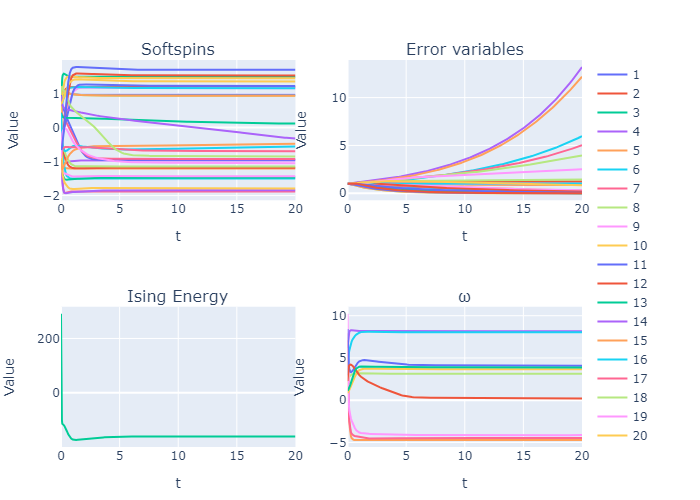

In [50]:
traces = [scatter(x = sol.t, y = [vec[n] for vec in sol.u], name = string(n)) for n in 1:M];
layout1 = Layout(title="Softspins",
                   xaxis_title="t",
                   yaxis_title="Value")
p1() = plot(traces, layout1);

auxs = [scatter(x = sol.t, y = [vec[m] for vec in sol.u], name = string(m)) for m in M+1:2M];
layout2 = Layout(title="Error variables",
                   xaxis_title="t",
                   yaxis_title="Value")
p2() = plot(auxs, layout2);

energies = [ get_ω(s_t[1:M], state_sizes)'*(J *get_ω(s_t[1:M], state_sizes)) for s_t in sol.u]
layout3 = Layout(title="Ising Energy",
                   xaxis_title="t",
                   yaxis_title="Value")   

ω_trj = [ get_ω(s_t[1:M], state_sizes)' for s_t in sol.u]
traces2 = [scatter(x = sol.t, y = [ω[i] for ω in ω_trj], name = string(i)) for i in 1:N];
layout4 = Layout(title="ω",
                    xaxis_title="t",
                    yaxis_title="Value")
p4() = plot(traces2, layout4);


p3() = plot(scatter(x=sol.t, y= energies), layout3);
p = [p1() p2(); p3() p4()]

